# MYSQL 연동

In [1]:
import mysql.connector
from mysql.connector import connect,Error
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='default')

In [3]:
def create_mysql_connection(host, user, password, database):
    try:
        connection = connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        if connection.is_connected():
            print(f'Connected to MySQL server : {host}')
        return connection
    except Error as e:
        print(f'Error: {e}')
        return None

def close_connection(connection):
    if connection:
        connection.close()
        print('Connection to MYSQL closed.')

In [4]:
connection = create_mysql_connection('localhost', 'root', '579579', 'yammer')

Connected to MySQL server : localhost


In [ ]:
#close_connection(connection)

# 1. Search Use
### 1-1. Session Usage of Search Autocomplete VS Search Run

In [37]:
sessions_sa_vs_sr_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
)

SELECT STR_TO_DATE(DATE_FORMAT(DATE_SUB(occurred_at_min, INTERVAL WEEKDAY(occurred_at_min) DAY), '%Y-%m-%d'), '%Y-%m-%d') weekstart,
		COUNT(*) engagement_sessions,
        COUNT(CASE WHEN search_runs>0 THEN ss ELSE NULL END) search_runs_sessions,
        COUNT(CASE WHEN search_autocompletes>0 THEN ss ELSE NULL END) search_autocompletes_sessions
FROM (
	SELECT user_id, ss, occurred_at_min,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes
	FROM events_ss
	GROUP BY user_id, ss, occurred_at_min
) temp
GROUP BY STR_TO_DATE(DATE_FORMAT(DATE_SUB(occurred_at_min, INTERVAL WEEKDAY(occurred_at_min) DAY), '%Y-%m-%d'), '%Y-%m-%d')
ORDER BY weekstart
"""
sessions_sa_vs_sr = pd.read_sql(sessions_sa_vs_sr_q, connection)
sessions_sa_vs_sr

,weekstart,engagement_sessions,search_runs_sessions,search_autocompletes_sessions
0,None,38,0,0
1,2014-04-28,966,88,217
2,2014-05-05,1995,176,439
3,2014-05-12,2014,159,473
4,2014-05-19,2084,178,482
5,2014-05-26,1988,169,463
6,2014-06-02,2166,179,492
7,2014-06-09,2181,183,499
8,2014-06-16,2261,174,516
9,2014-06-23,2259,177,520


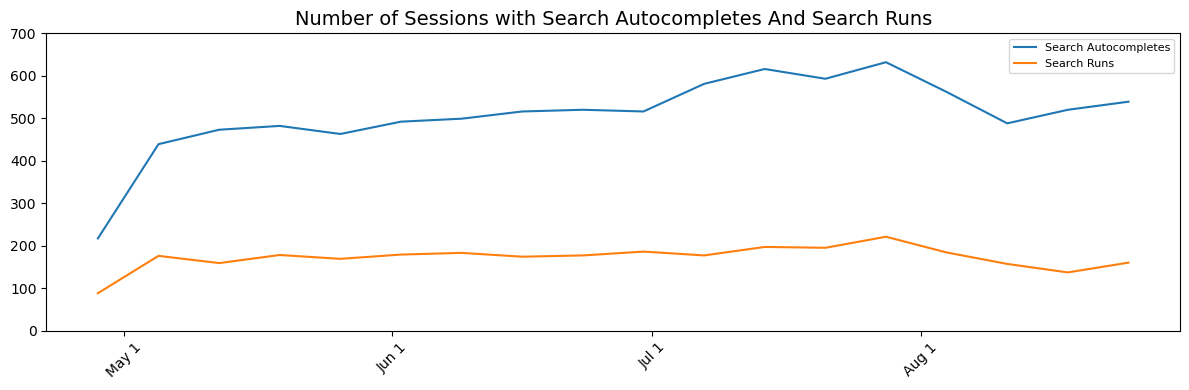

In [42]:
# 1) date를 확실하게 datetime으로
sessions_sa_vs_sr['weekstart'] = pd.to_datetime(sessions_sa_vs_sr['weekstart'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()

ax.plot(sessions_sa_vs_sr.weekstart, sessions_sa_vs_sr.search_autocompletes_sessions, label='Search Autocompletes')
ax.plot(sessions_sa_vs_sr.weekstart, sessions_sa_vs_sr.search_runs_sessions, label='Search Runs')

ax.legend(fontsize=8)
plt.title('Number of Sessions with Search Autocompletes And Search Runs',fontsize=14)
plt.ylim([0, 700])

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = sessions_sa_vs_sr['weekstart'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = sessions_sa_vs_sr['weekstart'].max().replace(day=1)  # 끝 달의 1일
# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()

### 1-2. Usage Rate of Engagement with Search Autocomplete VS Search run

In [5]:
persent_sa_vs_sr_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
)

SELECT STR_TO_DATE(DATE_FORMAT(DATE_SUB(occurred_at_min, INTERVAL WEEKDAY(occurred_at_min) DAY), '%Y-%m-%d'), '%Y-%m-%d') weekstart,
		COUNT(CASE WHEN search_runs>0 THEN ss ELSE NULL END)/COUNT(*) percent_with_runs,
        COUNT(CASE WHEN search_autocompletes>0 THEN ss ELSE NULL END)/COUNT(*) percent_with_autocompletes
FROM (
	SELECT user_id, ss, occurred_at_min,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes
	FROM events_ss
	GROUP BY user_id, ss, occurred_at_min
) temp
GROUP BY STR_TO_DATE(DATE_FORMAT(DATE_SUB(occurred_at_min, INTERVAL WEEKDAY(occurred_at_min) DAY), '%Y-%m-%d'), '%Y-%m-%d')
ORDER BY weekstart
"""
persent_sa_vs_sr = pd.read_sql(persent_sa_vs_sr_q, connection)
persent_sa_vs_sr

,weekstart,percent_with_runs,percent_with_autocompletes
0,None,0.0000,0.0000
1,2014-04-28,0.0911,0.2246
2,2014-05-05,0.0882,0.2201
3,2014-05-12,0.0789,0.2349
4,2014-05-19,0.0854,0.2313
5,2014-05-26,0.0850,0.2329
6,2014-06-02,0.0826,0.2271
7,2014-06-09,0.0839,0.2288
8,2014-06-16,0.0770,0.2282
9,2014-06-23,0.0784,0.2302


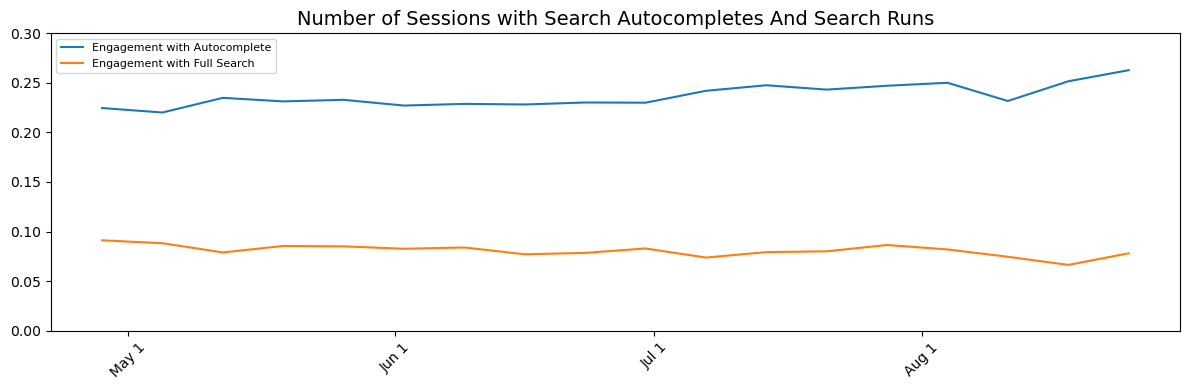

In [10]:
# 1) date를 확실하게 datetime으로
persent_sa_vs_sr['weekstart'] = pd.to_datetime(persent_sa_vs_sr['weekstart'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()

ax.plot(persent_sa_vs_sr.weekstart, persent_sa_vs_sr.percent_with_autocompletes, label='Engagement with Autocomplete')
ax.plot(persent_sa_vs_sr.weekstart, persent_sa_vs_sr.percent_with_runs, label='Engagement with Full Search')

ax.legend(fontsize=8)
plt.title('Number of Sessions with Search Autocompletes And Search Runs',fontsize=14)
plt.ylim([0, 0.3])

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = persent_sa_vs_sr['weekstart'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = persent_sa_vs_sr['weekstart'].max().replace(day=1)  # 끝 달의 1일
# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()

# 2. Search Frequency in A Session
### 2-1. Number of Sessions according to the Number of Search Autocompletes in A Session

In [16]:
ss_sa_ss_cnt_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
),
temp AS (
	SELECT user_id, ss, occurred_at_min,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes
	FROM events_ss
	GROUP BY occurred_at_min, ss, user_id#user_id, ss, occurred_at_min
)
SELECT search_autocompletes, COUNT(ss) session_count
FROM temp
WHERE search_autocompletes>0
GROUP BY search_autocompletes
ORDER BY search_autocompletes
"""
ss_sa_ss_cnt = pd.read_sql(ss_sa_ss_cnt_q, connection)
ss_sa_ss_cnt

,search_autocompletes,session_cnt
0,1,5368
1,2,1685
2,3,908
3,4,518
4,5,269
5,6,195
6,7,83
7,8,44
8,9,37
9,10,19


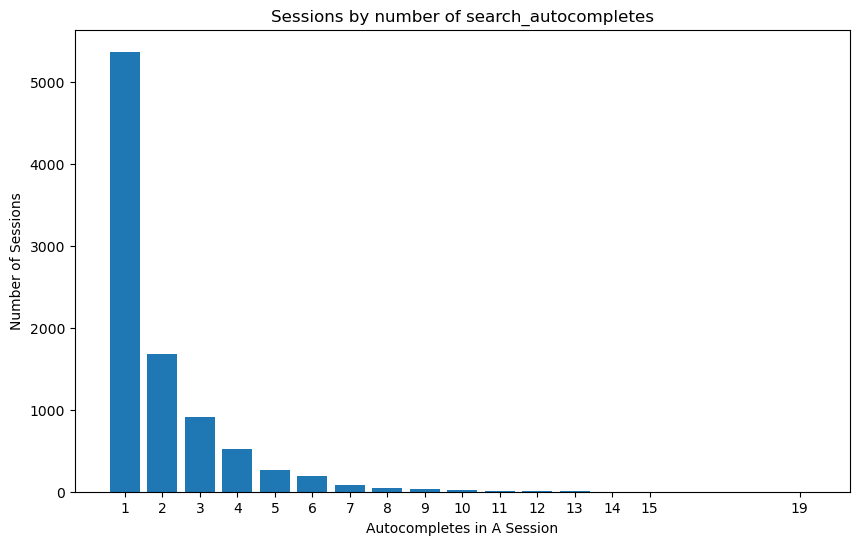

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(
    ss_sa_ss_cnt['search_autocompletes'],
    ss_sa_ss_cnt['session_cnt']
)

plt.xlabel('Autocompletes in A Session')
plt.ylabel('Number of Sessions')
plt.title('Sessions by number of search_autocompletes')

plt.xticks(ss_sa_ss_cnt['search_autocompletes'])  # x축 값 그대로 표시
plt.show()


### 2-2.  Number of Sessions according to the Number of Search Runs in A Session

In [18]:
ss_sr_ss_cnt_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
),
temp AS (
	SELECT user_id, ss, occurred_at_min,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes
	FROM events_ss
	GROUP BY occurred_at_min, ss, user_id#user_id, ss, occurred_at_min
)
SELECT search_runs, COUNT(ss) session_cnt
FROM temp
WHERE search_runs>0
GROUP BY search_runs
ORDER BY search_runs
"""
ss_sr_ss_cnt = pd.read_sql(ss_sr_ss_cnt_q, connection)
ss_sr_ss_cnt

,search_runs,session_cnt
0,1,352
1,2,601
2,3,589
3,4,458
4,5,326
5,6,236
6,7,189
7,8,108
8,9,85
9,10,56


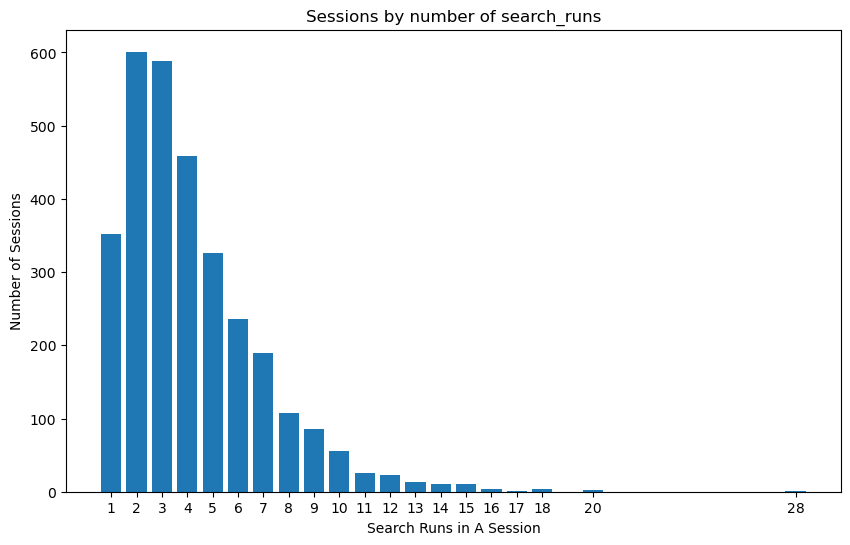

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(
    ss_sr_ss_cnt['search_runs'],
    ss_sr_ss_cnt['session_cnt']
)

plt.xlabel('Search Runs in A Session')
plt.ylabel('Number of Sessions')
plt.title('Sessions by number of search_runs')

plt.xticks(ss_sr_ss_cnt['search_runs'])  # x축 값 그대로 표시
plt.show()


# 3. Clickthroughs
### 3-1. Number of Sessions according to Number of Clickthrough after at least one search

In [22]:
click_ss_cnt_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
),
temp AS (
	SELECT user_id, ss, occurred_at_min,
			COUNT(*) engagement,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes,
            COUNT(CASE WHEN event_name LIKE 'search_click_%' THEN user_id ELSE NULL END) search_clicks_x
	FROM events_ss
	GROUP BY occurred_at_min, ss, user_id#user_id, ss, occurred_at_min
)

SELECT search_clicks_x, COUNT(ss) session_cnt
FROM temp
WHERE search_runs>0
GROUP BY search_clicks_x
ORDER BY search_clicks_x
"""
click_ss_cnt = pd.read_sql(click_ss_cnt_q, connection)
click_ss_cnt

,search_clicks_x,session_cnt
0,0,1681
1,1,76
2,2,154
3,3,160
4,4,146
5,5,151
6,6,135
7,7,108
8,8,94
9,9,93


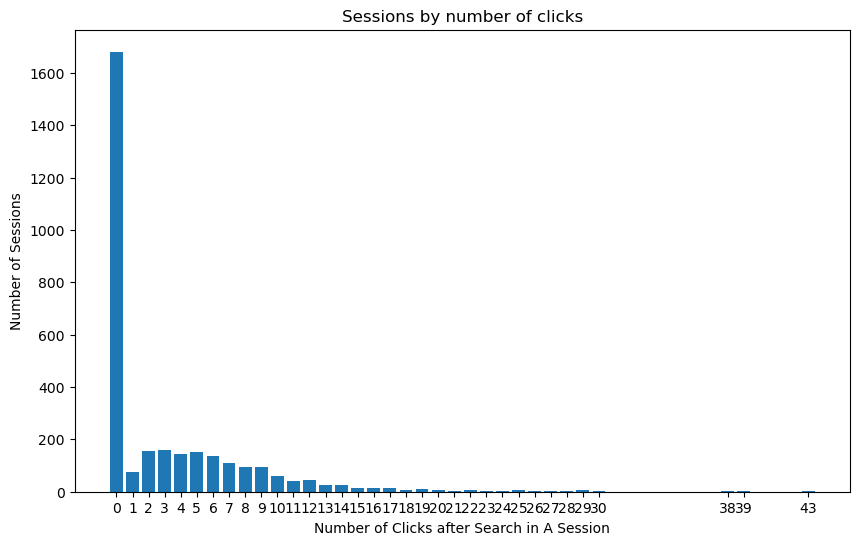

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(
    click_ss_cnt['search_clicks_x'],
    click_ss_cnt['session_cnt']
)

plt.xlabel('Number of Clicks after Search in A Session')
plt.ylabel('Number of Sessions')
plt.title('Sessions by number of clicks')

plt.xticks(click_ss_cnt['search_clicks_x'])  # x축 값 그대로 표시
plt.show()


### 3-2. Average Clicks per Session by Searches per Session

In [28]:
ss_search_ss_click_avg_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
),
temp AS (
	SELECT user_id, ss, occurred_at_min,
			COUNT(*) engagement,
			COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_runs,
			COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_autocompletes,
            COUNT(CASE WHEN event_name LIKE 'search_click_%' THEN user_id ELSE NULL END) search_clicks_x
	FROM events_ss
	GROUP BY occurred_at_min, ss, user_id#user_id, ss, occurred_at_min
)

SELECT search_runs search_num_ss, AVG(search_clicks_x) click_avg
FROM temp
WHERE search_runs>0
GROUP BY search_runs
ORDER BY search_runs
"""
ss_search_ss_click_avg = pd.read_sql(ss_search_ss_click_avg_q, connection)
ss_search_ss_click_avg

,search_num_ss,click_avg
0,1,0.7260
1,2,1.6163
2,3,1.9932
3,4,3.0459
4,5,4.0703
5,6,3.9237
6,7,4.9841
7,8,5.8165
8,9,7.3882
9,10,7.3036


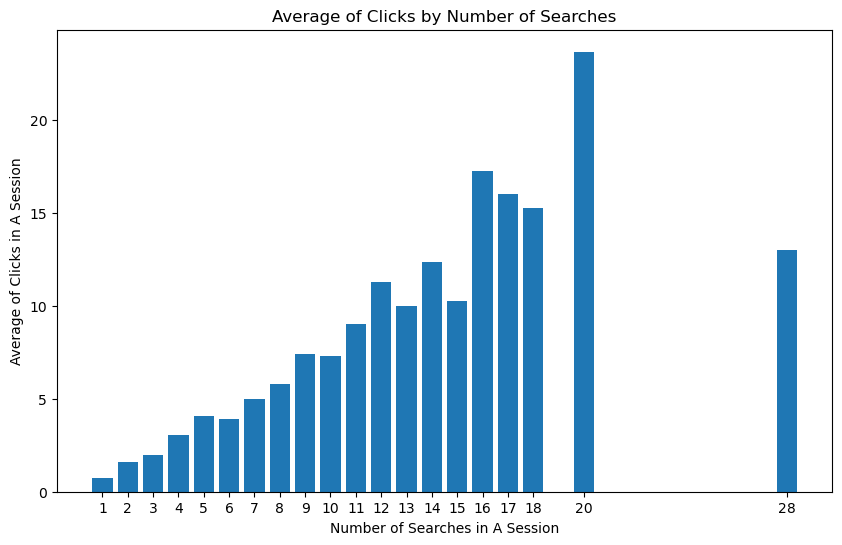

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(
    ss_search_ss_click_avg['search_num_ss'],
    ss_search_ss_click_avg['click_avg']
)

plt.xlabel('Number of Searches in A Session')
plt.ylabel('Average of Clicks in A Session')
plt.title('Average of Clicks by Number of Searches')

plt.xticks(ss_search_ss_click_avg['search_num_ss'])  # x축 값 그대로 표시
plt.show()


# 4. Search Rankings

In [36]:
rk_clicks_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) occurred_at_min, MAX(occurred_at) occurred_at_max
	FROM idx
	GROUP BY user_id, ss
),
events_ss AS (
	SELECT events.user_id, events.occurred_at, events.event_type, events.event_name, ss_mm.ss, ss_mm.occurred_at_min
	FROM events LEFT JOIN ss_mm ON(events.user_id=ss_mm.user_id AND events.occurred_at>=ss_mm.occurred_at_min AND events.occurred_at<=occurred_at_max)
	WHERE events.event_type='engagement'
)

SELECT (CASE WHEN event_name LIKE '%1' THEN 1 
			   WHEN event_name LIKE '%2' THEN 2
               WHEN event_name LIKE '%3' THEN 3
               WHEN event_name LIKE '%4' THEN 4
               WHEN event_name LIKE '%5' THEN 5
               WHEN event_name LIKE '%6' THEN 6
               WHEN event_name LIKE '%7' THEN 7
               WHEN event_name LIKE '%8' THEN 8
               WHEN event_name LIKE '%9' THEN 9
               WHEN event_name LIKE '%10' THEN 10 END) result_order, COUNT(ss) clicks_cnt
FROM events_ss
WHERE event_name LIKE 'search_click_%'
GROUP BY event_name
ORDER BY (CASE WHEN event_name LIKE '%1' THEN 1 
			   WHEN event_name LIKE '%2' THEN 2
               WHEN event_name LIKE '%3' THEN 3
               WHEN event_name LIKE '%4' THEN 4
               WHEN event_name LIKE '%5' THEN 5
               WHEN event_name LIKE '%6' THEN 6
               WHEN event_name LIKE '%7' THEN 7
               WHEN event_name LIKE '%8' THEN 8
               WHEN event_name LIKE '%9' THEN 9
               WHEN event_name LIKE '%10' THEN 10 END)
"""
rk_clicks = pd.read_sql(rk_clicks_q, connection)
rk_clicks

,result_order,clicks_cnt
0,1,1411
1,2,1497
2,3,1132
3,4,1264
4,5,966
5,6,805
6,7,707
7,8,688
8,9,781
9,10,506


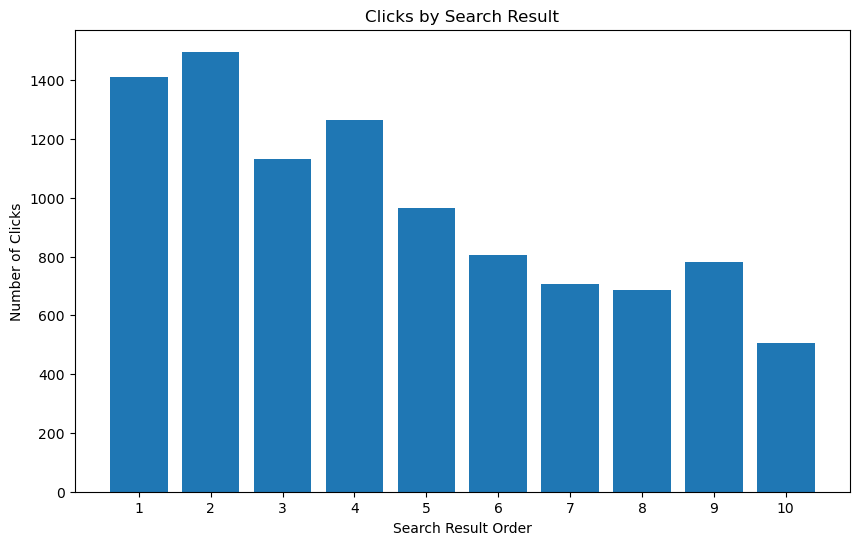

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(
    rk_clicks['result_order'],
    rk_clicks['clicks_cnt']
)

plt.xlabel('Search Result Order')
plt.ylabel('Number of Clicks')
plt.title('Clicks by Search Result')

plt.xticks(rk_clicks['result_order'])  # x축 값 그대로 표시
plt.show()


# 5. Retained Users
### 5-1. Sessions with Search Autocomplete in A Month after Users' First Search

In [39]:
retain_sa_ss_user_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY occurred_at) AS rn, #ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn) OVER (PARTITION BY user_id ORDER BY occurred_at) END ss #LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) session_start, MAX(occurred_at) session_end
	FROM idx
	GROUP BY user_id, ss
),
first_search AS (
SELECT user_id, MIN(occurred_at) occurred_at_min
FROM events
WHERE event_name='search_autocomplete'
GROUP BY user_id
),
first_search_user_ss_lb AS (
SELECT events.*, first_search.occurred_at_min first_search_at, ss_mm.ss, ss_mm.session_start
FROM events INNER JOIN first_search ON (events.user_id=first_search.user_id AND first_search.occurred_at_min<='2014-08-01')
			LEFT JOIN ss_mm ON (events.user_id=ss_mm.user_id AND 
									ss_mm.session_start<=DATE_ADD(first_search.occurred_at_min, INTERVAL 30 DAY) AND
									events.occurred_at<=ss_mm.session_end AND
                                    events.occurred_at>=ss_mm.session_start)
WHERE events.event_type='engagement'
),
ss_search_cnt AS (
	SELECT ss, session_start, user_id, COUNT(CASE WHEN event_name='search_autocomplete' THEN user_id ELSE NULL END) search_cnt
	FROM first_search_user_ss_lb
	GROUP BY user_id, ss, session_start
)

SELECT search_ss_cnt, COUNT(user_id) users_cnt
FROM (
SELECT user_id, COUNT(*) search_ss_cnt #COUNT(ss) search_ss_cnt
FROM ss_search_cnt
WHERE search_cnt>0
GROUP BY user_id
) temp
GROUP BY search_ss_cnt
ORDER BY search_ss_cnt
"""
retain_sa_ss_user = pd.read_sql(retain_sa_ss_user_q, connection)
retain_sa_ss_user

,search_ss_cnt,users_cnt
0,1,1239
1,2,1003
2,3,516
3,4,237
4,5,112
5,6,66
6,7,25
7,8,6
8,9,3


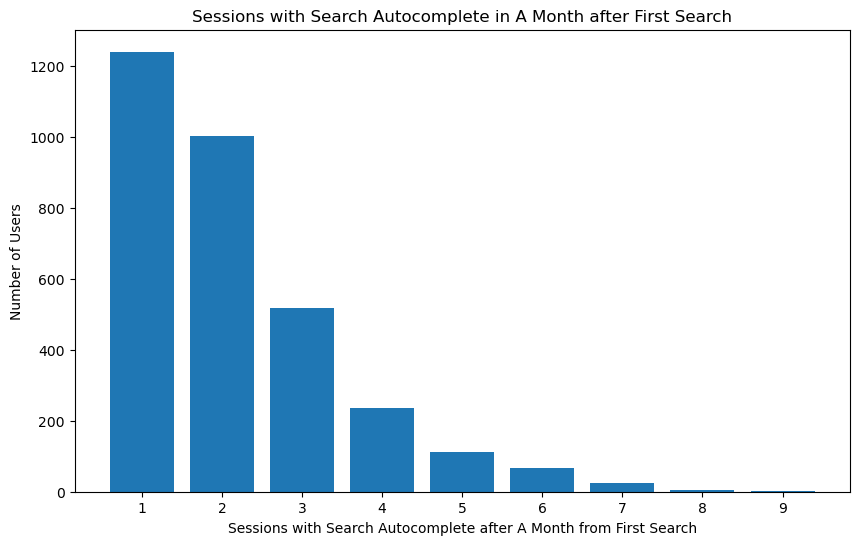

In [40]:
plt.figure(figsize=(10, 6))
plt.bar(
    retain_sa_ss_user['search_ss_cnt'],
    retain_sa_ss_user['users_cnt']
)

plt.xlabel('Sessions with Search Autocomplete after A Month from First Search')
plt.ylabel('Number of Users')
plt.title('Sessions with Search Autocomplete in A Month after First Search')

plt.xticks(retain_sa_ss_user['search_ss_cnt'])  # x축 값 그대로 표시
plt.show()


### 5-2. Sessions with Search Runs in A Month after Users' First Search

In [41]:
retain_sr_ss_user_q = """
WITH time_diff AS (
	SELECT *,
		ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY occurred_at) AS rn, #ROW_NUMBER() OVER() rn,
		TIMESTAMPDIFF(MINUTE, LAG(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at), occurred_at) pre_diff,
        TIMESTAMPDIFF(MINUTE, occurred_at, LEAD(occurred_at, 1) OVER (PARTITION BY user_id ORDER BY occurred_at)) post_diff
	FROM events
	WHERE event_type='engagement'
    ORDER BY rn
),
idx AS (
	SELECT *,
			CASE WHEN pre_diff IS NULL THEN rn
				WHEN pre_diff >= 10 THEN rn
				ELSE LAG(rn) OVER (PARTITION BY user_id ORDER BY occurred_at) END ss #LAG(rn, 1) OVER (ORDER BY rn) END ss
	FROM time_diff
	WHERE (pre_diff>=10 OR post_diff>=10) OR (pre_diff IS NULL OR post_diff IS NULL)
),
ss_mm AS ( 
	SELECT user_id, ss, MIN(occurred_at) session_start, MAX(occurred_at) session_end
	FROM idx
	GROUP BY user_id, ss
),
first_search AS (
SELECT user_id, MIN(occurred_at) occurred_at_min
FROM events
WHERE event_name='search_run'
GROUP BY user_id
),
first_search_user_ss_lb AS (
SELECT events.*, first_search.occurred_at_min first_search_at, ss_mm.ss, ss_mm.session_start
FROM events INNER JOIN first_search ON (events.user_id=first_search.user_id AND first_search.occurred_at_min<='2014-08-01')
			LEFT JOIN ss_mm ON (events.user_id=ss_mm.user_id AND 
									ss_mm.session_start<=DATE_ADD(first_search.occurred_at_min, INTERVAL 30 DAY) AND
									events.occurred_at<=ss_mm.session_end AND
                                    events.occurred_at>=ss_mm.session_start)
WHERE events.event_type='engagement'
),
ss_search_cnt AS (
	SELECT ss, session_start, user_id, COUNT(CASE WHEN event_name='search_run' THEN user_id ELSE NULL END) search_cnt
	FROM first_search_user_ss_lb
	GROUP BY user_id, ss, session_start
)

SELECT search_ss_cnt, COUNT(user_id) users_cnt
FROM (
SELECT user_id, COUNT(*) search_ss_cnt #COUNT(ss) search_ss_cnt
FROM ss_search_cnt
WHERE search_cnt>0
GROUP BY user_id
) temp
GROUP BY search_ss_cnt
ORDER BY search_ss_cnt
"""
retain_sr_ss_user = pd.read_sql(retain_sr_ss_user_q, connection)
retain_sr_ss_user

,search_ss_cnt,users_cnt
0,1,1177
1,2,428
2,3,119
3,4,23
4,5,6
5,6,1
6,7,1


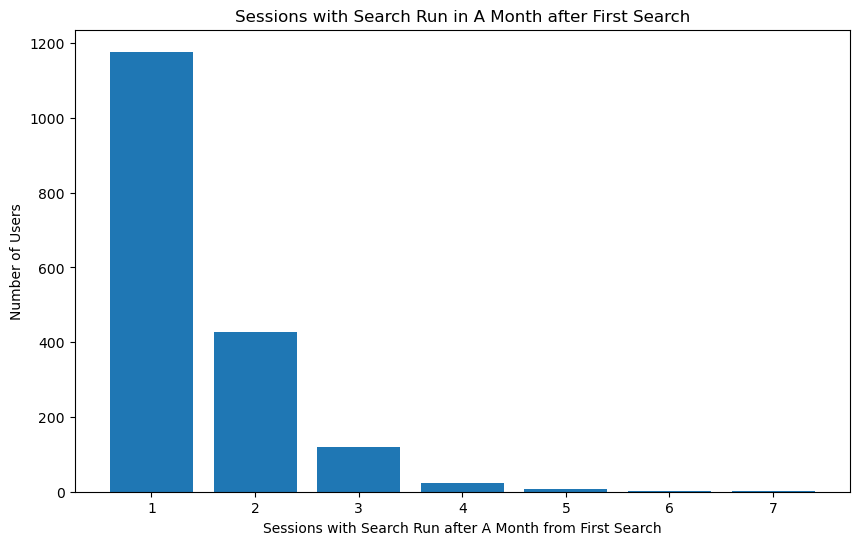

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(
    retain_sr_ss_user['search_ss_cnt'],
    retain_sr_ss_user['users_cnt']
)

plt.xlabel('Sessions with Search Run after A Month from First Search')
plt.ylabel('Number of Users')
plt.title('Sessions with Search Run in A Month after First Search')

plt.xticks(retain_sr_ss_user['search_ss_cnt'])  # x축 값 그대로 표시
plt.show()
